# EDA presupuestos

### Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))  # Agranda el ancho de la ventana.

In [2]:
import pandas as pd
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', 1000)  
pd.set_option('display.max_columns', 1000) 
pd.options.display.float_format = '{:.2f}'.format

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [185]:
%run Funciones_Auxiliares.ipynb

# Lectura de la base unificada y selección de los campos a analizar

La base contiene todos los gastos que demande el desenvolvimiento de los órganos del gobierno central, de los entes descentralizados y comunas, el servicio de la deuda pública, las inversiones patrimoniales y los recursos para cubrir tales erogaciones. Los recursos publicados detallan la distribución de los créditos aprobados al máximo nivel de desagregación.

De todas las áreas querremos analizar la destinada a espacios verdes.

In [85]:
presupuesto_sancionado = pd.read_csv("datasets/presupuesto_sancionado_clean.csv")

In [86]:
presupuesto_sancionado['SANCION'] = presupuesto_sancionado['SANCION'].astype(float)

In [87]:
presupuesto_sancionado = presupuesto_sancionado.loc[presupuesto_sancionado['SANCION'] != 0]
presupuesto_sancionado = presupuesto_sancionado.loc[presupuesto_sancionado['AÑO'] > 2009]

In [88]:
presupuesto_sancionado.AÑO.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

In [89]:
presupuesto_sancionado.shape

(401068, 22)

In [90]:
cols = presupuesto_sancionado.dtypes[(presupuesto_sancionado.dtypes == 'object')].index
for col in cols:
    presupuesto_sancionado[col] = presupuesto_sancionado[col].astype(str)

In [91]:
for col in cols:
    print(col, presupuesto_sancionado.loc[presupuesto_sancionado[col].str.contains('AMBIENTE'), col].unique())

    print(col, presupuesto_sancionado[col].str.contains('AMBIENTE').sum())

    print()

CARACTER []
CARACTER 0

JURISDICCION ['MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO']
JURISDICCION 40142

SUBJURISDICCION ['MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO' 'SECRETARIA DE AMBIENTE']
SUBJURISDICCION 41141

ENTIDAD ['MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO' 'SECRETARIA DE AMBIENTE']
ENTIDAD 29001

SERVICIO ['MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO' 'SEC. AMBIENTE']
SERVICIO 29001

UNIDAD_EJECUTORA ['MINISTERIO AMBIENTE Y ESPACIO PUBLICO'
 'MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO']
UNIDAD_EJECUTORA 1371

PROGRAMA ['ACTIVIDADES CENTRALES AMBIENTE Y ESPACIO PUBLICO']
PROGRAMA 1232

SUBPROGRAMA ['ACTIVIDADES CENTRALES AMBIENTE Y ESPACIO PUBLICO']
SUBPROGRAMA 1232

PROYECTO ['ACTIVIDADES CENTRALES AMBIENTE Y ESPACIO PUBLICO']
PROYECTO 1232

ACTIVIDAD []
ACTIVIDAD 0

OBRA ['AMBIENTE Y ESPACIO PUBLICO']
OBRA 3

FINALIDAD []
FINALIDAD 0

FUNCION []
FUNCION 0

INCISO []
INCISO 0

PRINCIPAL []
PRINCIPAL 0

PARCIAL []
PARCIAL 0

SUBPARCIAL []
SUBPARCIAL 0

CLAS_ECONOMICO []
CLAS_ECONOMICO 

**El Ministerio de Ambiente pasa a ser una secretaria en 2020 bajo la dependencia de la Jefatura de Gobierno**

In [92]:
jef_gob = presupuesto_sancionado.groupby('JURISDICCION').get_group("JEFATURA DE GOBIERNO")
sec_ambiente = jef_gob.groupby('SUBJURISDICCION').get_group("SECRETARIA DE AMBIENTE")
min_ambiente = presupuesto_sancionado.groupby('JURISDICCION').get_group("MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO")

ambiente = pd.concat([min_ambiente, sec_ambiente])

In [93]:
ambiente['JURISDICCION'].value_counts()

MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO    40142
JEFATURA DE GOBIERNO                         1248
Name: JURISDICCION, dtype: int64

In [94]:
ambiente['FUNCION'].value_counts()

SERVICIOS URBANOS                17757
ECOLOGIA                         17417
AGUA POTABLE Y ALCANTARILLADO     1486
SEGURIDAD INTERIOR                1480
TRABAJO                           1289
INDUSTRIA Y COMERCIO              1255
DIRECCION EJECUTIVA                340
CONTROL DE LA GESTION              194
PROMOCION Y ACCION SOCIAL           83
EDUCACION                           51
SALUD                               38
Name: FUNCION, dtype: int64

In [95]:
ecologia = ambiente[ambiente['FUNCION'] == 'ECOLOGIA']
ecologia = ecologia.T.drop_duplicates().T  # Elimino columnas que contienen la misma información.

In [96]:
ecologia.shape

(17417, 21)

In [97]:
def repr_high_values(series):

        series = series.apply(lambda x: f"${x:,.0f}" if not pd.isnull(x) else x)
        series = series.str.replace(",", ".")

        return series

In [98]:
def repr_sancion_by_subset(df, subset):

    sancion_by_subset = df.groupby(subset).agg({'SANCION': 'sum'})\
                                .sort_values(by='SANCION', ascending=False)
    
    sancion_by_subset['SANCION_repr'] = repr_high_values(sancion_by_subset['SANCION'])
    
    return sancion_by_subset

In [99]:
ecologia['SANCION'] = ecologia['SANCION'].astype(float)

In [100]:
sancion_por_unidad_ejecutora_año = ecologia.pivot_table(index='AÑO', columns='UNIDAD_EJECUTORA', values='SANCION', aggfunc='sum')
sancion_por_unidad_ejecutora_año.loc['Total'] = sancion_por_unidad_ejecutora_año.apply('sum', axis=0) 
sancion_por_unidad_ejecutora_año = sancion_por_unidad_ejecutora_año.T.sort_values(by='Total', ascending=False).T

sancion_por_unidad_ejecutora_año = sancion_por_unidad_ejecutora_año.apply(repr_high_values, axis=1).fillna('-')

sancion_por_unidad_ejecutora_año.T.head(8).T

UNIDAD_EJECUTORA,DIRECCION GENERAL DE ESPACIOS VERDES,MINISTERIO AMBIENTE Y ESPACIO PUBLICO,AGENCIA AMBIENTAL,DIRECCION GENERAL DE LIMPIEZA,UPE ECOPARQUE,DIRECCION GENERAL DE CONTROL,UPE ECOPARQUE INTERACTIVO DE LA CABA,DIRECCION GENERAL DE ARBOLADO
AÑO,,,,,,,,
2010,$146.668.026,$38.084.880,$14.923.403,$127.527.400,-,$10.766.941,-,$43.122.015
2011,$182.039.510,$68.517.305,$32.563.320,-,-,$21.151.940,-,$64.493.450
2012,$222.624.631,$100.779.083,$54.986.204,-,-,$25.179.169,-,$61.170.726
2013,$306.709.216,$169.267.432,$72.848.780,-,-,$20.069.991,-,$30.258.926
2014,$322.560.420,$193.351.900,$59.441.809,$51.969.614,-,$23.531.004,-,$23.341.940
2015,$472.147.712,$234.650.667,$70.025.885,$32.017.440,-,$40.675.736,-,-
2016,$572.810.988,$454.087.661,$118.034.376,$95.616.323,-,$52.159.459,-,-
2017,$848.066.208,$253.895.885,$166.254.462,$128.619.395,-,$78.202.278,-,-
2018,$1.000.632.878,$237.399.998,$164.934.725,$224.316.115,-,$92.794.733,-,-


1. DIRECCION GENERAL DE ESPACIOS VERDES: https://www.buenosaires.gob.ar/gestioncomunal/institucional-subsecretaria-de-gestion-comunal/direccion-general-de
2. DIRECCION GENERAL DE ARBOLADO: https://www.buenosaires.gob.ar/gestioncomunal/institucional-subsecretaria-de-gestion-comunal/dg-de-arbolado

In [101]:
sancion_por_unidad_ejecutora_año[["DIRECCION GENERAL DE ESPACIOS VERDES", 'DIRECCION GENERAL DE ARBOLADO']]

UNIDAD_EJECUTORA,DIRECCION GENERAL DE ESPACIOS VERDES,DIRECCION GENERAL DE ARBOLADO
AÑO,,
2010,$146.668.026,$43.122.015
2011,$182.039.510,$64.493.450
2012,$222.624.631,$61.170.726
2013,$306.709.216,$30.258.926
2014,$322.560.420,$23.341.940
2015,$472.147.712,-
2016,$572.810.988,-
2017,$848.066.208,-
2018,$1.000.632.878,-


**Los datos sobre la dirección general de arbolado están desactualizados.**

**Y Falta información del 2020 sobre espacios verdes**

### Acá filtramos la base finalmente para espacios verdes

Los datos de arbolados en principio no se usarán por estar desactualizados

In [102]:
espacios_verdes = ecologia[ecologia['UNIDAD_EJECUTORA'] == 'DIRECCION GENERAL DE ESPACIOS VERDES']

In [103]:
espacios_verdes.shape

(4226, 21)

### Sanción de presupuesto por año para Espacios Verdes

In [104]:
sancion_por_unidad_ejecutora_año[["DIRECCION GENERAL DE ESPACIOS VERDES"]].T

AÑO,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
UNIDAD_EJECUTORA,,,,,,,,,,,,
DIRECCION GENERAL DE ESPACIOS VERDES,$146.668.026,$182.039.510,$222.624.631,$306.709.216,$322.560.420,$472.147.712,$572.810.988,$848.066.208,$1.000.632.878,$1.453.447.832,-,$5.527.707.421


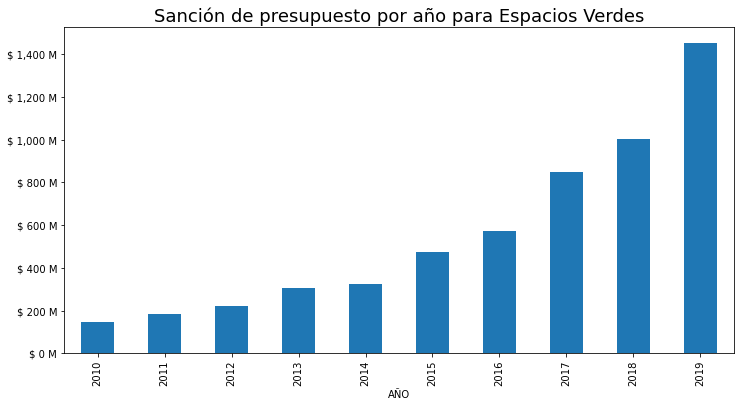

In [105]:
sancion_espacios_verdes_año = espacios_verdes.groupby('AÑO').agg({'SANCION': 'sum'})['SANCION']
g = sancion_espacios_verdes_año.plot(kind='bar', figsize=(12, 6));

ylabels = ['$ {:,.0f}'.format(x) + ' M' for x in g.get_yticks()/1000000];
g.set_yticklabels(ylabels);
plt.title("Sanción de presupuesto por año para Espacios Verdes", fontsize=18);

### Pasaremos los datos de presupuestos a valores del 2010 para ver si realmente aumentó la inversión en el área

In [106]:
# http://estudiodelamo.com/inflacion-argentina-anual-mensual-2020/

header = ["AÑO","PORC_ANUAL", "ENE","FEB","MAR","ABR","MAY","JUN","JUL","AGO","SEP","OCT","NOV","DIC"]
inflacion = pd.DataFrame(([ 2011,  23.97, 2.10, 1.50, 2.10, 1.80, 1.33, 1.56, 1.66, 1.85, 1.82, 1.52, 1.46, 1.86],
                          [ 2012,  25.98, 1.84, 1.79, 2.27, 2.19, 1.81, 1.63, 1.80, 1.93, 1.92, 1.72, 1.81, 2.04],
                          [ 2013,  23.28, 2.61, 1.14, 1.50, 1.43, 1.63, 2.19, 2.63, 2.14, 2.12, 2.11, 2.38, 3.30],
                          [ 2014,  38.53, 4.62, 4.31, 3.42, 2.59, 2.28, 2.20, 2.47, 2.65, 2.48, 2.25, 1.86, 1.87],
                          [ 2015,  27.50, 2.08, 1.48, 2.12, 2.01, 2.00, 1.53, 1.92, 2.17, 1.92, 1.52, 2.20, 3.80],
                          [ 2016,  40.30, 3.60, 4.80, 3.20, 6.70, 3.50, 2.90, 2.40, 0.50, 0.80, 2.90, 1.90, 1.60],
                          [ 2017,  24.80, 1.60, 2.10, 2.20, 2.10, 1.80, 1.30, 2.10, 1.50, 1.60, 1.50, 1.40, 3.10],
                          [ 2018,  47.65, 1.76, 2.42, 2.34, 2.74, 2.08, 3.74, 3.10, 3.89, 6.53, 5.39, 3.15, 2.57],
                          [ 2019,  53.83, 2.91, 3.77, 4.68, 3.44, 3.06, 2.72, 2.20, 3.95, 5.89, 3.29, 4.25, 3.74],
                          [ 2020,  36.62, 2.25, 2.01, 3.34, 1.50, 1.54, 2.24, 1.93, 2.70, 2.84,]), columns=header)

inflacion

,AÑO,PORC_ANUAL,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
0,2011,23.97,2.10,1.50,2.10,1.80,1.33,1.56,1.66,1.85,1.82,1.52,1.46,1.86
1,2012,25.98,1.84,1.79,2.27,2.19,1.81,1.63,1.80,1.93,1.92,1.72,1.81,2.04
2,2013,23.28,2.61,1.14,1.50,1.43,1.63,2.19,2.63,2.14,2.12,2.11,2.38,3.30
3,2014,38.53,4.62,4.31,3.42,2.59,2.28,2.20,2.47,2.65,2.48,2.25,1.86,1.87
4,2015,27.50,2.08,1.48,2.12,2.01,2.00,1.53,1.92,2.17,1.92,1.52,2.20,3.80
5,2016,40.30,3.60,4.80,3.20,6.70,3.50,2.90,2.40,0.50,0.80,2.90,1.90,1.60
6,2017,24.80,1.60,2.10,2.20,2.10,1.80,1.30,2.10,1.50,1.60,1.50,1.40,3.10
7,2018,47.65,1.76,2.42,2.34,2.74,2.08,3.74,3.10,3.89,6.53,5.39,3.15,2.57
8,2019,53.83,2.91,3.77,4.68,3.44,3.06,2.72,2.20,3.95,5.89,3.29,4.25,3.74
9,2020,36.62,2.25,2.01,3.34,1.50,1.54,2.24,1.93,2.70,2.84,nan,nan,nan


In [107]:
inflacion_anual = inflacion.set_index('AÑO')['PORC_ANUAL'] / 100
inflacion_anual

AÑO
2011   0.24
2012   0.26
2013   0.23
2014   0.39
2015   0.28
2016   0.40
2017   0.25
2018   0.48
2019   0.54
2020   0.37
Name: PORC_ANUAL, dtype: float64

In [108]:
def presupuestos_a_valores_2010(sancion_espacios_verdes_año):
    presupuestos_llevados_2010 = []
    for start_year, presupuesto in sancion_espacios_verdes_año.items():
#         print('Pesos presupuestados finales del año {}:  $ {:,.0f}'.format(start_year, presupuesto))

        for tasa_inflacion in inflacion_anual.loc[start_year::-1]:

            presupuesto = presupuesto / (1+tasa_inflacion)

        presupuestos_llevados_2010.append(presupuesto)    
#         print("Pesos finales llevados a principios 2010:   $ {:,.0f}\n".format(presupuesto))

    presupuestos_llevados_2010 = pd.Series(presupuestos_llevados_2010)
    presupuestos_llevados_2010.index = sancion_espacios_verdes_año.index
    
    return presupuestos_llevados_2010

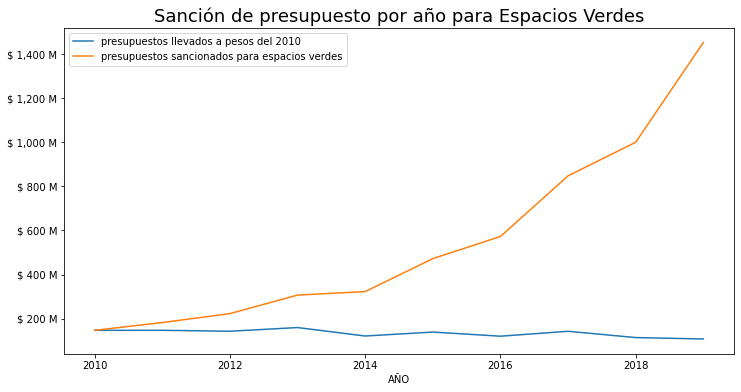

In [109]:
presupuestos_llevados_2010 = presupuestos_a_valores_2010(sancion_espacios_verdes_año)

aux = pd.concat([presupuestos_llevados_2010, sancion_espacios_verdes_año], axis=1)
aux.columns = ['presupuestos llevados a pesos del 2010', 'presupuestos sancionados para espacios verdes']
g = aux.plot(figsize=(12,6))

ylabels = ['$ {:,.0f}'.format(x) + ' M' for x in g.get_yticks()/1000000];
g.set_yticklabels(ylabels);
plt.title("Sanción de presupuesto por año para Espacios Verdes", fontsize=18);

In [110]:
presupuestos_llevados_2010 = presupuestos_llevados_2010.reset_index()
presupuestos_llevados_2010.columns = ['AÑO', 'SANCION']
presupuestos_llevados_2010['SANCION_repr'] = repr_high_values(presupuestos_llevados_2010['SANCION'])

In [111]:
presupuestos_llevados_2010 = presupuestos_llevados_2010.set_index('AÑO')
presupuestos_llevados_2010.T

AÑO,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
SANCION,146668026.00,146841582.64,142545990.94,159300080.38,120936225.75,138839499.54,120057368.33,142427106.82,113816233.87,107470148.95
SANCION_repr,$146.668.026,$146.841.583,$142.545.991,$159.300.080,$120.936.226,$138.839.500,$120.057.368,$142.427.107,$113.816.234,$107.470.149


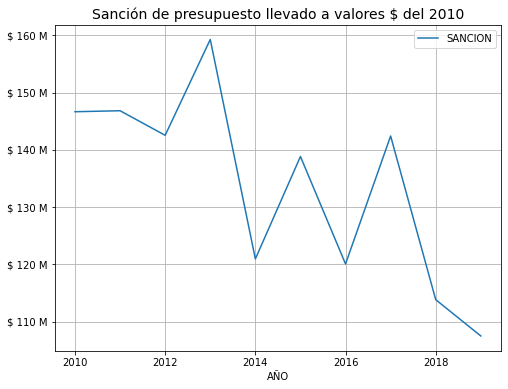

In [112]:
g = presupuestos_llevados_2010.plot(figsize=(8, 6))

ylabels = ['$ {:,.0f}'.format(x) + ' M' for x in g.get_yticks()/1000000];
g.set_yticklabels(ylabels);
plt.title("Sanción de presupuesto llevado a valores $ del 2010", fontsize=14);
plt.grid(True);

**Se puede observar que la inversión real en el área viene bajando año a año con picos en los años impares**

**Esta subida seguro viene asociada a años electorales**


### Sanciones por Proyecto, Actividad y Obra.

In [113]:
aux = espacios_verdes[espacios_verdes.AÑO==2019]

In [114]:
aux[aux.PROYECTO=='OBRAS BA ELIGE EV']

,CARACTER,JURISDICCION,SUBJURISDICCION,ENTIDAD,SERVICIO,UNIDAD_EJECUTORA,PROGRAMA,PROYECTO,ACTIVIDAD,OBRA,FINALIDAD,FUNCION,INCISO,PRINCIPAL,PARCIAL,SUBPARCIAL,CLAS_ECONOMICO,FUENTE_FIN,UBICACION_GEOGRAFICA,SANCION,AÑO
583152,ADMINISTRACION CENTRAL,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,DIRECCION GENERAL DE ESPACIOS VERDES,CUIDADO Y PUESTA EN VALOR DE ESPACIOS VERDES,OBRAS BA ELIGE EV,PARQUE DE VOLEY PLAYA- VELODROMO,PARQUE DE VOLEY PLAYA- VELODROMO,SERVICIOS ECONOMICOS,ECOLOGIA,BIENES DE USO,CONSTRUCCIONES,CONSTRUCCIONES EN BIENES DE DOMINIO PUBLICO,CONSTRUCCIONES EN BIENES DE DOMINIO PUBLICO,GASTOS DE CAPITAL,TESORO DE LA CIUDAD,COMUNA 14,3500000.00,2019
583153,ADMINISTRACION CENTRAL,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,DIRECCION GENERAL DE ESPACIOS VERDES,CUIDADO Y PUESTA EN VALOR DE ESPACIOS VERDES,OBRAS BA ELIGE EV,PARQUE DE VOLEY PLAYA- VELODROMO,NUEVO CIRCUITO AEROBICO AGRONOMIA,SERVICIOS ECONOMICOS,ECOLOGIA,BIENES DE USO,CONSTRUCCIONES,CONSTRUCCIONES EN BIENES DE DOMINIO PUBLICO,CONSTRUCCIONES EN BIENES DE DOMINIO PUBLICO,GASTOS DE CAPITAL,TESORO DE LA CIUDAD,COMUNA 15,2752834.00,2019
583154,ADMINISTRACION CENTRAL,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,MINISTERIO DE AMBIENTE Y ESPACIO PUBLICO,DIRECCION GENERAL DE ESPACIOS VERDES,CUIDADO Y PUESTA EN VALOR DE ESPACIOS VERDES,OBRAS BA ELIGE EV,PARQUE DE VOLEY PLAYA- VELODROMO,NUEVOS ESPACIOS VERDES EN LATERALES VIAS DEL TREN VILLA DEL PARQUE,SERVICIOS ECONOMICOS,ECOLOGIA,BIENES DE USO,CONSTRUCCIONES,CONSTRUCCIONES EN BIENES DE DOMINIO PUBLICO,CONSTRUCCIONES EN BIENES DE DOMINIO PUBLICO,GASTOS DE CAPITAL,TESORO DE LA CIUDAD,COMUNA 11,1000000.00,2019


In [115]:
repr_sancion_by_subset(aux, subset='PROYECTO')

,SANCION,SANCION_repr
PROYECTO,,
VALORIZACION DE LOS ESPACIOS VERDES,1040075483.00,$1.040.075.483
CUIDADO Y PUESTA EN VALOR DE ESPACIOS VERDES,273729024.00,$273.729.024
OBRAS DE ESPACIOS VERDES II,102530490.00,$102.530.490
OBRAS DE ESPACIOS VERDES,29860001.00,$29.860.001
OBRAS BA ELIGE EV,7252834.00,$7.252.834


In [116]:
repr_sancion_by_subset(aux, subset='ACTIVIDAD')

,SANCION,SANCION_repr
ACTIVIDAD,,
PRESERVACION Y PUESTA EN VALOR DE ESPEJOS DE AGUA,1040075483.00,$1.040.075.483
ADMINISTRACION Y SERVICIOS GENERALES,106641842.00,$106.641.842
PARQUE ESTACION BUENOS AIRES,102530490.00,$102.530.490
"MANTENIMIENTO DE FUENTES, MONUMENTOS Y OBRAS DE ARTE",39905314.00,$39.905.314
CONDUCCION,38925455.00,$38.925.455
LICITACION PUBLICA MANTENIMIENTO INTEGRAL DE MUROS VERDES Y ZONAS ANEXAS,29860001.00,$29.860.001
CUIDADO Y PUESTA EN VALOR PATRIMONIO CULTURAL Y NATURAL DE LOS ESPACIOS VERDES,25357681.00,$25.357.681
"JARDIN BOTANICO ""CARLOS THAYS""",22597092.00,$22.597.092
RESERVA ECOLOGICA COSTANERA SUR,20198341.00,$20.198.341


In [190]:
sancion_obras = repr_sancion_by_subset(espacios_verdes, subset='OBRA')

In [203]:
def pie_chart(data, categorias):
    
    data = data.to_list()
    categorias = categorias.to_list()
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(categorias[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Cantidad presupuestada por Obras", fontsize=16)

    percents = [str(round((x/np.array(data).sum())*100, 1))+"%   " + y for x, y in zip(data, categorias)]
    plt.legend(wedges, percents, loc='right center', bbox_to_anchor=(0, -0.2),
               fontsize=14)
    plt.tight_layout()
    plt.show()

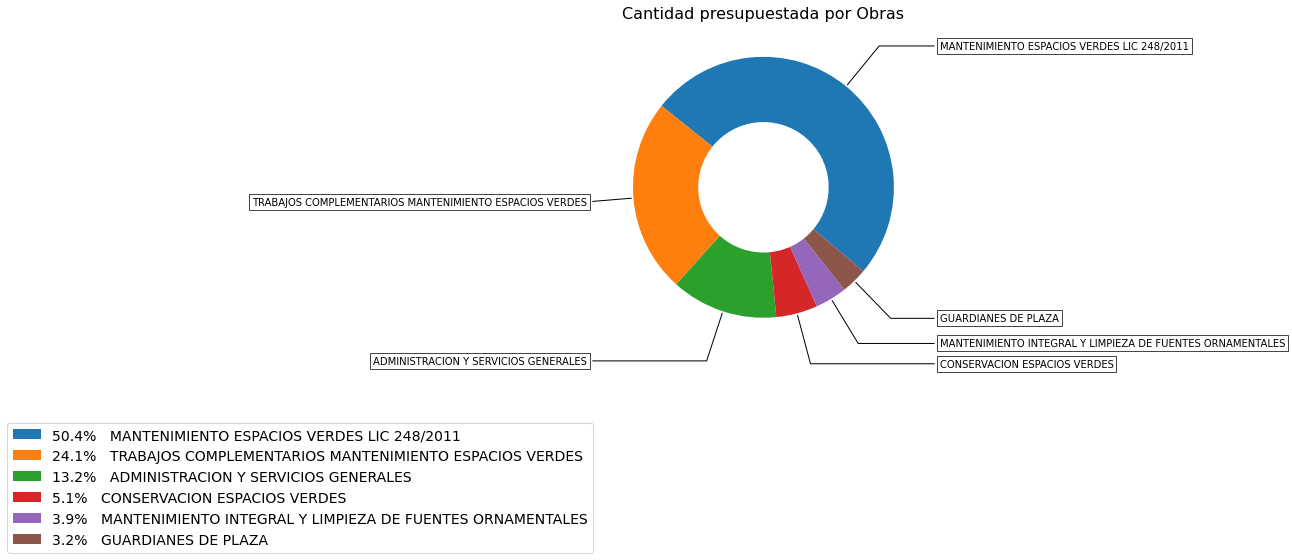

In [204]:
pie_chart(data= sancion_obras['SANCION'].head(6), categorias=sancion_obras.head(6).index)

### Sanción por Comuna

In [119]:
sancion_espacios_verdes = repr_sancion_by_subset(espacios_verdes, subset=['AÑO', 'UBICACION_GEOGRAFICA']).reset_index()

In [181]:
sancion_espacios_verdes = sancion_espacios_verdes.loc[sancion_espacios_verdes['UBICACION_GEOGRAFICA'] != "A CLASIFICAR"]

In [184]:
sancion_espacios_verdes['AÑO'] = sancion_espacios_verdes['AÑO'].astype('category')


fig = px.bar(aux,
             title="<b>Sanción por Comuna<b>")
fig = fig.update_layout(
    title={
        'y':0.9,
        'x':0.135,
        'xanchor': 'left',
        'yanchor': 'top'},
        plot_bgcolor='white')

fig = fig.update_layout(yaxis_tickformat = '$,.')

fig.show()

In [182]:
fig = px.bar(sancion_espacios_verdes, x="AÑO", y="SANCION", color="UBICACION_GEOGRAFICA",
             title="<b>Sanción por Comuna<b>")
fig = fig.update_layout(
    title={
        'y':0.9,
        'x':0.135,
        'xanchor': 'left',
        'yanchor': 'top'},
        plot_bgcolor='white')

fig = fig.update_layout(yaxis_tickformat = '$,.')

fig.show()

In [183]:
aux = sancion_espacios_verdes.groupby('UBICACION_GEOGRAFICA').sum().sort_values(by='SANCION', ascending=False)

1. **Comuna 1:**  Sigue tendencia creciente
9. **Comuna 9:**  Sigue tendencia creciente
6. **Comuna 6:**  Sigue tendencia creciente
12. **Comuna 12:** Sigue tendencia creciente
13. **Comuna 13:** Sigue tendencia creciente
15. **Comuna 15:** Sigue tendencia creciente


2. **Comuna 2:**  Revisar datos. En 2016 hay una caida muy fuerte.
7. **Comuna 7:**  Caida en 2016
8. **Comuna 8:**  Brusca caida 2016 y 2017. Pico fuerte en 2019
10. **Comuna 10:** Brusca caida 2016 y 2017. Pico fuerte en 2019



3. **Comuna 3:**  Picos de inversión muy fuertes en 2014 y 2019
4. **Comuna 4:**  Pico de inversión muy fuerte en 2019

5. **Comuna 5:**  Mayor inversión en 2014, cae mucho en 2016.
11. **Comuna 11:** Inversión hasta 2015 y luego cae bruscamente y queda en niveles bajos.
14. **Comuna 14:** Inversión hasta 2017, cae en los últimos años



In [158]:
c3 = espacios_verdes.loc[(espacios_verdes['UBICACION_GEOGRAFICA']=='COMUNA 2')]
c3.groupby(['AÑO', 'OBRA']).sum().unstack().loc[2015:2019].dropna(how='all', axis=1)
# espacios_verdes.loc[(espacios_verdes['UBICACION_GEOGRAFICA']=='COMUNA 2')&(espacios_verdes['AÑO']==2018)]

SANCION                                             \
OBRA ARBOLES HISTORICOS CEMENTERIO RECOLETA CINERARIO Y MURO VERDE   
AÑO                                                                  
2015                nan                                        nan   
2016                nan                                        nan   
2017                nan                                 5000000.00   
2018          405380.00                                        nan   
2019         1697342.00                                        nan   

                                                                             \
OBRA MANTENIMIENTO DE MONUMENTOS MANTENIMIENTO ESPACIOS VERDES LIC 248/2011   
AÑO                                                                           
2015                         nan                                16222050.00   
2016                         nan                                        nan   
2017                         nan                                        nan   
2018                   846170.00                                 4563810.00   
2019                  1140305.00                                 5058288.00   

                                                                \
OBRA MANTENIMIENTO INTEGRAL Y LIMPIEZA DE FUENTES ORNAMENTALES   
AÑO                                                              
2015                                                1333333.00   
2016                                                3048276.00   
2017                                                       nan   
2018                                                3917730.00   
2019                                                4414097.00   

                                               \
OBRA PROVISION Y EJECUCION DE SOLADO DRENANTE   
AÑO                                             
2015                                      nan   
2016                                      nan   
2017                                      nan   
2018                               1094520.00   
2019                               1196992.00   

                                                             
OBRA TRABAJOS COMPLEMENTARIOS MANTENIMIENTO ESPACIOS VERDES  
AÑO                                                          
2015                                                    nan  
2016                                                    nan  
2017                                                    nan  
2018                                             2353010.00  
2019                                            33716071.00

### Búsqueda de match por categoría de espacios verdes

In [122]:
a = espacios_verdes['ACTIVIDAD'].unique()
a[['PARQUE' in x for x in a]]

array(['PARQUE 3 DE FEBRERO',
       'CUIDADO Y PUESTA EN VALOR DE GRANDES PARQUES',
       'PARQUE AVELLANEDA', 'PARQUE INDOAMERICANO',
       'PARQUE TRES DE FEBRERO - APERTURA GOLF MUNICIPAL',
       'PARQUE DE LOS NIÑOS SECTOR LADO PROVINCIA',
       'REUCN PARQUE URBANO Y RESERVA', 'PARQUE CHACABUCO',
       'PARQUE ISLA DE LA PATERNAL', 'PARQUE LAS HERAS', 'PARQUE ALBERDI',
       'PARQUE DE VOLEY PLAYA- VELODROMO', 'PARQUE ESTACION BUENOS AIRES'],
      dtype=object)

In [123]:
a.tolist()

['CONDUCCION',
 'ADMINISTRACION Y SERVICIOS GENERALES',
 'CONTROL Y MANTENIMIENTO DE ESPACIOS VERDES',
 'ESTUDIOS Y PROYECTOS',
 'SERVICIOS ESPECIALES',
 'GUARDIANES DE PLAZA',
 'PARQUE 3 DE FEBRERO',
 'RESERVA ECOLOGICA "COSTANERA SUR"',
 'JARDIN BOTANICO "CARLOS THAYS"',
 'VALORIZACION DE LOS ESPACIOS VERDES DE LA CIUDAD',
 'ESTUDIOS, INVESTIGACIONES Y PROYECTOS DE FACTIBILIDAD',
 'CUIDADO Y PUESTA EN VALOR DE GRANDES PARQUES',
 'CUIDADO Y PUESTA EN VALOR DEL PATRIMONIO CULTURAL Y NATURAL DE LOS ESPACIOS VERDES',
 'OPERATIVOS DE CONTROL Y MANTENIMIENTO DE ESPACIOS VERDES',
 'PARQUE AVELLANEDA',
 'PARQUE INDOAMERICANO',
 'PUESTA EN VALOR EDIFICIOS',
 'CUIDADO Y PUESTA EN VALOR PATRIMONIO CULTURAL Y NATURAL DE LOS ESPACIOS VERDES',
 'RESERVA ECOLOGICA COSTANERA SUR',
 'VALORIZACION DE LOS ESPACIOS VERDES',
 'CUIDADO Y PUESTA EN VALOR PARIMONIO CULTURAL Y NATURAL DE LOS ESPACIOS VERDES',
 'CUIDADO Y PRESERVACION DEL ARBOLADO URBANO',
 'JARDIN BOTANICO CARLOS THAYS',
 'A.CU.MAR - VALORIZ

In [124]:
espacios_verdes['PROYECTO'].unique().tolist()

['CUIDADO Y PUESTA EN VALOR DE ESPACIOS VERDES',
 'VALORIZACION DE LOS ESPACIOS VERDES DE LA CIUDAD',
 'CUIDADO Y PUESTA EN VALOR DE GRANDES PARQUES',
 'CUIDADO Y PUESTA EN VALOR DEL PATRIMONIO CULTURAL Y NATURAL DE LOS ESPACIOS VERDES',
 'PUESTA EN VALOR EDIFICIOS',
 'VALORIZACION DE LOS ESPACIOS VERDES',
 'CUIDADO Y PRESERVACION DEL ARBOLADO URBANO',
 'JARDIN BOTANICO CARLOS THAYS',
 'A.CU.MAR - VALORIZACION DE LOS ESPACIOS VERDES',
 'OBRAS DE ESPACIOS VERDES',
 'OBRAS BA ELIGE EV',
 'OBRAS DE ESPACIOS VERDES II']

In [125]:
clasificaciones_espacios_verdes = ['PLAZOLETA', 'PARQUE', 'PLAZA', 'CANTERO', 'JARDIN',
                                   'PASEO', 'PATIO',
                                   'BARRIO', 'COMPLEJO', 'JARDIN BOTANICO',]

**plazoleta, barrio, complejo, cantero central . No se encuentran en espacios verdes pero hay referencias en otras categorías.**

In [130]:
for clas in clasificaciones_espacios_verdes:
 
    for col in presupuesto_sancionado.loc[:, 'PROGRAMA':'OBRA'].columns:
        
        print(col, clas, presupuesto_sancionado[col].str.contains(clas).sum())
        print(presupuesto_sancionado.loc[presupuesto_sancionado[col].str.contains(clas), col].unique())

        print()

PROGRAMA PLAZOLETA 0
[]

SUBPROGRAMA PLAZOLETA 0
[]

PROYECTO PLAZOLETA 0
[]

ACTIVIDAD PLAZOLETA 0
[]

OBRA PLAZOLETA 14
['PLAZOLETA WILLIAM MORRIS' 'PLAZOLETA GUANELLA' 'PLAZOLETA DISCEPOLO'
 'PLAZOLETA HOMERO MANZI' 'PLAZOLETA JOSE LUIS ROMERO'
 'PLAZOLETA AGUSTIN MAGALDI / MIGUEL UNAMUNO' 'PLAZOLETA TRONCOSO'
 'PLAZOLETA VERACRUZ - VALPARAISO Y MARACAIBO']

PROGRAMA PARQUE 1740
['GESTION DEL PARQUE DE LA MEMORIA Y DEL MONUMENTO A LAS VICTIMAS'
 'PARQUE DE LA CIUDAD' 'RECUPERACION BARRIO PARQUE DONADO-HOLMBERG'
 'PARQUE DE LA INNOVACION']

SUBPROGRAMA PARQUE 1740
['GESTION DEL PARQUE DE LA MEMORIA Y DEL MONUMENTO A LAS VICTIMAS'
 'PARQUE DE LA CIUDAD' 'RECUPERACION BARRIO PARQUE DONADO-HOLMBERG'
 'PARQUE DE LA INNOVACION']

PROYECTO PARQUE 1789
['GESTION DEL PARQUE DE LA MEMORIA Y DEL MONUMENTO A LAS VICTIMAS'
 'CENTRO RECREATIVO PARQUE SARMIENTO'
 'CUIDADO Y PUESTA EN VALOR DE GRANDES PARQUES' 'PARQUE DE LA CIUDAD'
 'OBRAS EN PARQUE DE LA CIUDAD' 'PUESTA EN VALOR DEL PARQUE SARMIEN

PROGRAMA PLAZA 0
[]

SUBPROGRAMA PLAZA 0
[]

PROYECTO PLAZA 1
['ANFITEATRO INTERRELIGIOSO PLAZA CAMPAÑA DE CHACO']

ACTIVIDAD PLAZA 337
['GUARDIANES DE PLAZA' 'PLAZAS ACTIVAS'
 'PUESTA EN VALOR DE LA PLAZA LAVALLE'
 'AREA AMBIENTAL SALTA / BRASIL + ENTORNO PLAZA CONSTITUCION.'
 'RECOLETA ETAPA II - PLAZA INTENDENTE ALVEAR Y ENTORNO. JUAN XXIII'
 'ENTORNO PLAZA MISERERE (ONCE)'
 'ACCESO ESTACION TRIBUNALES PLAZA LAVALLE'
 '2DA ETAPA PM CHACARITA PLAZAS SOBRE GUZMAN'
 '2DA ETAPA PM CHACARITA PLAZA NEWBERY Y TRASL. OSARIO'
 '2DA ETAPA SENDEROS JARDIN BOTANICO, INGRESO PLAZA ITALIA'
 'PLAZAS PROVINCIALES 9 DE JULIO' 'PLAZA GOULD PUESTA EN VALOR INTEGRAL'
 'PLAZA SICILIA RECUPERACION Y PUESTA EN VALOR'
 'PLAZA HAITI RECUPERACION Y PUESTA EN VALOR'
 'TRATAMIENTO CALLE LA PAMPA Y PLAZA RUSIA' 'PUESTA EN VALOR PLAZA EGIPTO'
 'PLAZA PUEYRREDON' 'PLAZA DE MAYO' 'PLAZA CONGRESO'
 'ANFITEATRO INTERRELIGIOSO PLAZA CAMPAÑA DE CHACO' 'PLAZA ROMA'
 'PLAZA BARRIAL ETAPA 1']

OBRA PLAZA 430
['DEMOLICION

PROGRAMA PASEO 0
[]

SUBPROGRAMA PASEO 0
[]

PROYECTO PASEO 2
['MANTENIMIENTO PASEO DE LAS FLORES']

ACTIVIDAD PASEO 42
['PASEO PORTEÑO DE LAS COLECTIVIDADES' 'MANTENIMIENTO PASEO DE LAS FLORES'
 'PUESTA EN VALOR DE LA FERIA DE RETIRO Y PASEO COMERCIAL DEL PLAYON'
 'METROBUS ALEM-PASEO COLON']

OBRA PASEO 103
['REPARACION Y/O MANTENIMIENTO DE VEREDAS PERIMETRALES EN BARRIOS Y PASEOS PUBLICOS'
 'ESCUELA TECNICA NDA 1 - D.E. 4DA - AV.PASEO COLON 650'
 'REMODELACION NUEVO PASEO COSTANERA SUR'
 'ADULTOS 2000 ISAURO ARANCIBIA AVDA. PASEO COLON 1318'
 'EDIFICIO MINISTERIO EDUCACION AVDA. PASEO COLON 255'
 'REP. Y/O MANT. VER. PERI. EN CONJUNTOS HABIT. Y PASEOS PUBLICOS'
 'PUESTA EN VALOR PASEO COLON Y AV. ALEM'
 'PASEO PORTEÑO DE LAS COLECTIVIDADES'
 'ESCUELA TECNICA NU 01 PASEO COLON 650 TRABAJOS DE INTERVENCION GRAL E INS CONTRA INCENDIOS'
 'EDIFICIO MINISTERIO EDUCACION AVDA. PASEO COLON 255 - REFACCIONES'
 'MANTENIMIENTO PASEO DE LAS FLORES'
 'PUESTA EN VALOR DE LA FERIA DE RETIRO Y PASE

PROGRAMA JARDIN BOTANICO 0
[]

SUBPROGRAMA JARDIN BOTANICO 0
[]

PROYECTO JARDIN BOTANICO 1
['JARDIN BOTANICO CARLOS THAYS']

ACTIVIDAD JARDIN BOTANICO 432
['JARDIN BOTANICO "CARLOS THAYS"' 'JARDIN BOTANICO CARLOS THAYS'
 'NUEVO ACCESO JARDIN BOTANICO DE LA CIUDAD DE BUENOS AIRES CARLOS THAYS'
 '2DA ETAPA SENDEROS JARDIN BOTANICO, INGRESO PLAZA ITALIA']

OBRA JARDIN BOTANICO 437
['JARDIN BOTANICO "CARLOS THAYS"'
 'PRESERVACION Y PUESTA EN VALOR DEL JARDIN BOTANICO "CARLOS THAYS"'
 'CAMINOS INTERNOS JARDIN BOTANICO'
 'JARDIN BOTANICO - JARDIN DE LOS SENTIDOS'
 'JARDIN BOTANICO - ACCESO Y TRATAMIENTO DE SENDEROS - 2DA ETAPA'
 'JARDIN BOTANICO CARLOS THAYS'
 'NUEVO ACCESO JARDIN BOTANICO DE LA CIUDAD DE BUENOS AIRES CARLOS THAYS'
 '2DA ETAPA SENDEROS JARDIN BOTANICO, INGRESO PLAZA ITALIA']



In [127]:
espacios_verdes.loc[espacios_verdes['PROYECTO'] == "OBRAS DE ESPACIOS VERDES", "FUNCION"].value_counts()

ECOLOGIA    70
Name: FUNCION, dtype: int64

In [128]:
ecologia.loc[ecologia['UNIDAD_EJECUTORA'] == 'DIRECCION GENERAL DE ESPACIOS VERDES'].shape
# .unique().tolist()

(4226, 21)

In [129]:
espacios_verdes.shape

(4226, 21)

In [62]:
df.loc[(df['OBRA'] == "CANTEROS CENTRALES CALABRIA")|(df['OBRA'] == "CANTEROS CENTRALES RAMON L.FALCON")]



NameError: name 'df' is not defined